### RGA

In [1]:
import matplotlib.pyplot as plt
import pyproj
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd

In [3]:
import requests

url = "https://georisques.gouv.fr//api/v1/rga"
params = {"latlon": "0.345234,45.576964"}  # code INSEE de Nice
response = requests.get(url, params=params)

if response.ok:
    data = response.json()
    print(data)
else:
    print("Erreur :", response.status_code)


{'codeExposition': '3', 'exposition': 'Exposition forte'}


In [2]:
df_spei = pd.read_csv('C:/Users/colin/Documents/Data/Météo-France/spei.csv', sep=',')
df_anomaly_temp = pd.read_csv('C:/Users/colin/Documents/Data/Météo-France/temperature_anomaly.csv', sep=',')
df_spei['lat'] = df_spei['ID'].str.split('_').str[0].astype(float)
df_spei['lon'] = df_spei['ID'].str.split('_').str[1].astype(float)
df_anomaly_temp['lat'] = df_anomaly_temp['ID'].str.split('_').str[0].astype(float)
df_anomaly_temp['lon'] = df_anomaly_temp['ID'].str.split('_').str[1].astype(float)
df_meta = pd.read_csv('C:/Users/colin/Downloads/coordonnees_grille_safran_lambert-2-etendu.csv', sep=';')
df_meta['LAT_DG'] = df_meta['LAT_DG'].str.replace(',', '.')
df_meta['LAT_DG'] = df_meta['LAT_DG'].astype(float)
df_meta['LON_DG'] = df_meta['LON_DG'].str.replace(',', '.')
df_meta['LON_DG'] = df_meta['LON_DG'].astype(float)
df_meta['LAMBX (hm)'] = df_meta['LAMBX (hm)'].astype(float)
df_meta['LAMBY (hm)'] = df_meta['LAMBY (hm)'].astype(float)
df_spei = df_spei.merge(df_meta, left_on=['lat', 'lon'], right_on=['LAMBX (hm)', 'LAMBY (hm)'], how='left')
df_anomaly_temp = df_anomaly_temp.merge(df_meta, left_on=['lat', 'lon'], right_on=['LAMBX (hm)', 'LAMBY (hm)'], how='left')
df_meta['ID'] = df_meta['LAMBX (hm)'].astype(int).astype(str) + '_' + df_meta['LAMBY (hm)'].astype(int).astype(str)

In [ ]:
df_spei = df_spei.set_index(['LAMBX (hm)', 'LAMBY (hm)', 'time'])
df_spei = df_spei.to_xarray()
df_spei = df_spei.rename({'LAMBX (hm)': 'x', 'LAMBY (hm)': 'y'})

In [8]:
df_spei['x'] = df_spei['x']*100
df_spei['y'] = df_spei['y']*100

In [9]:
def change_projection(da,plot=False):
    if plot:
        da.plot()
        plt.show()
        plt.close()
    new_lon_coords = np.linspace(-5, 9.8,134)
    new_lat_coords = np.linspace(41.3, 51.3, 143)
    lonmesh, latmesh = np.meshgrid(new_lon_coords, new_lat_coords)
    target_crs = pyproj.CRS(init="epsg:4326") # Coordinate system of the file
    # rp = ccrs.RotatedPole(pole_longitude=-162.0, pole_latitude=39.25)
    source_crs = pyproj.CRS(init="epsg:27572")
    latlon_to_rotpol = pyproj.Transformer.from_crs(target_crs, source_crs)
    x_om2, y_om2 = latlon_to_rotpol.transform(lonmesh, latmesh)
    x_om2 = xr.DataArray(x_om2, dims=('lat','lon'))
    y_om2 = xr.DataArray(y_om2, dims=('lat','lon'))
    da = da.interp({'x':x_om2, 'y':y_om2}, method='nearest').load()
    da = da.assign_coords({'lon': (('lon'),new_lon_coords), 'lat': (('lat'), new_lat_coords)}).drop_vars(['lon','lat'])
    da['lon'] = new_lon_coords
    da['lat'] = new_lat_coords
    if plot:
        da.plot()
        plt.show()
        plt.close()
    da = da.rename({'lon':'longitude','lat':'latitude'})
    da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    da.rio.write_crs(target_crs, inplace=True)
    return da

In [10]:
df_spei.spei.isel(time=0).mean()

<xarray.DataArray 'spei' ()>
array(0.98989898)
Coordinates:
    time     <U19 '1970-01-16 00:00:00'

In [53]:
d = change_projection(df_spei)

c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [58]:
d.ID

<xarray.DataArray 'ID' (x: 142, y: 134, time: 664)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=object)
Coordinates:
  * time         (time) object '1970-01-16 00:00:00' ... '2025-04-13 12:00:00'
  * x            (x) float64 6e+04 7.6e+04 8.4e+04 ... 1.188e+06 1.196e+06
  * y            (y) float64 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06
    spatial_ref  int32 0

In [14]:
#use xr.apply_ufunc to apply the change_projection function to the spei data for each time step
# xr.apply_ufunc is not suitable here because change_projection expects a DataArray, not a numpy array per time step.
# Instead, use xarray's .groupby or .map to apply the function along 'time' dimension.

df_spei_proj = xr.concat(
    [change_projection(df_spei.spei.isel(time=i)) for i in range(df_spei.spei.sizes['time'])],
    dim='time'
)
df_spei_proj['time'] = df_spei.spei['time']
df_spei_proj

c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<xarray.DataArray 'spei' (time: 664, latitude: 143, longitude: 134)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) object '1970-01-16 00:00:00' ... '2025-04-13 12:00:00'
    x            (latitude, longitude) float64 -1.623e+04 ... 1.121e+06
    y            (latitude, longitude) float64 1.617e+06 1.616e+06 ... 2.726e+06
  * longitude    (longitude) float64 -5.0 -4.889 -4.777 ... 9.577 9.689 9.8
  * latitude     (latitude) float64 41.3 41.37 41.44 41.51 ... 51.16 51.23 51.3
    spatial_ref  int32 0

In [24]:
df_spei_proj['time'] = pd.to_datetime(df_spei_proj['time'], format='%Y-%m-%d')


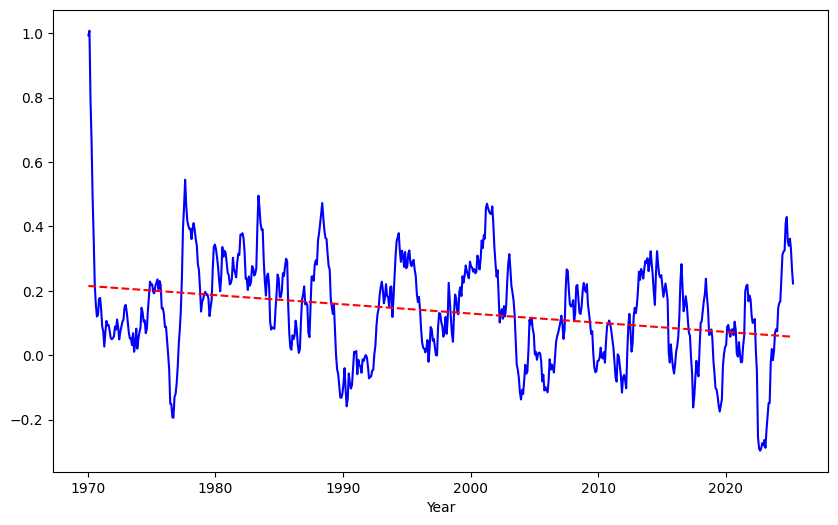

In [51]:

a = df_spei_proj.mean(dim=['longitude', 'latitude']).values
#rolling mean over the last 12 months
a = pd.Series(a).rolling(window=12, min_periods=1).mean().values
df_spei_proj['time'] = pd.to_datetime(df_spei_proj['time'].values)


fig, ax = plt.subplots(figsize=(10, 6))

#x is only the start of the year
ax.set_xlabel('Year')

x = df_spei_proj['time'].values
ax.plot(x, a, label='SPEI', color='blue')
#linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(np.arange(len(a)).reshape(-1, 1), a)
ax.plot(x, model.predict(np.arange(len(a)).reshape(-1, 1)), color='red', linestyle='--', label='Trend')
# ax.set_xticks(np.arange(df_spei_proj['time'].dt.year.min(), df_spei_proj['time'].dt.year.max() + 1, 1))


c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


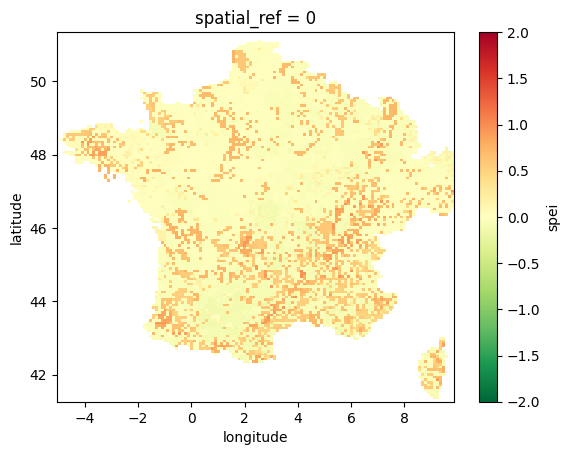

In [11]:
change_projection(df_spei.spei).mean(dim='time').plot(cmap='RdYlGn_r', vmin=-2, vmax=2)


c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\colin\anaconda3\envs\xarray_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


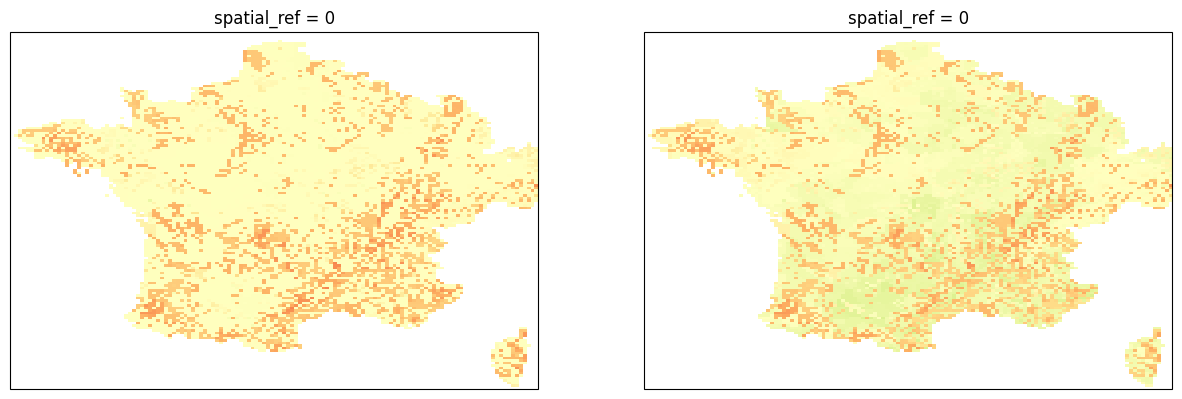

In [12]:
import cartopy.crs as ccrs

fig, axs = plt.subplots(1 ,2 , figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()})

change_projection(df_spei.spei).sel(time=slice('1970-01-01','1999-12-31')).mean(dim='time').plot(ax=axs[0], cmap='RdYlGn_r', vmin=-2, vmax=2, add_colorbar=False)
change_projection(df_spei.spei).sel(time=slice('2000-01-01','2020-12-31')).mean(dim='time').plot(ax=axs[1], cmap='RdYlGn_r', vmin=-2, vmax=2, add_colorbar=False)

In [ ]:
pop = gpd.read_file(os.path.join('data','INSEE','carreaux_1km_met.gpkg'))
pop = pop[['ind','geometry']]
pop = pop.to_crs("epsg:4326")
pop = pop.drop(columns="geometry").join(pop["geometry"].apply(lambda g: [g] if isinstance(g, shapely.geometry.Polygon) else g.geoms).explode().apply(lambda p: p.exterior.coords).explode().apply(pd.Series).rename(columns={0: "lon", 1: "lat"}))
pop = pop.groupby(by=['lon','lat'], as_index=False).mean()

bins_lon, bins_lat = 500,500
lon_simplified = np.linspace(pop.lon.min(),pop.lon.max(),bins_lon)
lat_simplified = np.linspace(pop.lat.min(),pop.lat.max(),bins_lat)
ind = np.zeros((bins_lat-1,bins_lon-1))
for i in tqdm.tqdm(range(len(lon_simplified)-1),total=bins_lon-1):
    for j in range(len(lat_simplified)-1):
        lon_min,lon_max = lon_simplified[i:i+2]
        lat_min,lat_max = lat_simplified[j:j+2]
        temp = pop[(pop.lat<=lat_max)&(pop.lat>lat_min)&(pop.lon<=lon_max)&(pop.lon>lon_min)]
        if temp.empty:
            val = np.nan
        else:
            val = temp.ind.sum()
        ind[j,i] = val

lon = np.asarray([(lon_simplified[i]+lon_simplified[i+1])/2 for i in range(len(lon_simplified)-1)])
lat = np.asarray([(lat_simplified[i]+lat_simplified[i+1])/2 for i in range(len(lat_simplified)-1)])

da = xr.DataArray(data=ind,
                  dims=["lat", "lon"],
                  coords=dict(lon=(lon),lat=(lat)),
                  attrs=dict(
                      description="Population 2019 (données carroyées à 1km INSEE). Maillage simplifié à {}x{} valeurs (lon,lat)".format(bins_lon-1, bins_lat-1),
                      units="inhab",
                      ),
                  )   

da = da.fillna(0)

shape = os.path.join('data','Meteo-France','gadm41_FRA_shp','gadm41_FRA_0.shp')
france = gpd.read_file(shape, crs="epsg:4326")

da.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
da.rio.write_crs("epsg:4326", inplace=True)
da = da.rio.clip(france.geometry.apply(mapping), france.crs, drop=False)


da.plot()


ds = da.to_dataset(name='population',promote_attrs=True)
ds.to_netcdf(os.path.join('data','INSEE','pop_carreaux_met.nc'))